In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import resample

In [ ]:
df = pd.read_csv("data/diabetic_data.csv")

# replacing ? with NaN
df = df.replace('?', np.nan)

df = df[df['readmitted'].isin(['<30', '>30', "NO"])]

# delete columns with more than 40% missing data
missing_threshold = 0.4
df = df.loc[:, df.isnull().mean() < missing_threshold]

# delete rows with missing values
df = df.dropna()

# Removing id and nbr
df = df.drop(['encounter_id', 'patient_nbr'], axis=1)

# Getting all categorical columns
categorical_cols = df.select_dtypes(include='object').columns.drop('readmitted')

# Doing one-hot encoding for the categorical columns, basically converting them to 0 or 1
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Setting readmitted to be 0, 1, or 2 based on class labels
df['readmitted'] = df['readmitted'].map({
    "NO": 0,
    "<30": 1,
    ">30": 2
})

print(f"Dataset shape after cleaning: {df.shape}")

Dataset shape after cleaning: (59129, 2163)


In [14]:
# Using random oversampling to adjust the data prior to working with it
print("Class distribution before balancing:")
print(df['readmitted'].value_counts())

# Getting index and number of the majority class in our dataset (Not readmitted)
majority = df['readmitted'].value_counts().idxmax()
majority_size = df['readmitted'].value_counts().max()

first_class = df[df["readmitted"] == 0]
second_class = df[df["readmitted"] == 1]
third_class = df[df["readmitted"] == 2]

# Using oversampling for both the minority classes
oversample_second_class = resample(second_class, replace=True, n_samples=majority_size, random_state=13)
oversample_third_class = resample(third_class, replace=True, n_samples=majority_size, random_state=13)

# Putting back the classes in to one dataframe and shuffling it
entire_dataframe = pd.concat([first_class, oversample_second_class, oversample_third_class])
entire_dataframe = entire_dataframe.sample(frac=1, random_state=13).reset_index(drop=True)
oversampled_df = entire_dataframe

print("\nClass distribution after balancing:")
print(oversampled_df['readmitted'].value_counts())

Class distribution before balancing:
readmitted
0    31457
2    21158
1     6514
Name: count, dtype: int64

Class distribution after balancing:
readmitted
1    31457
2    31457
0    31457
Name: count, dtype: int64


In [6]:
# Removing the readmitted column from the training data because we will use this to classify
X = df.drop("readmitted", axis=1)
y = df["readmitted"]

In [7]:
# Initially splitting the data with using 20% for testing
# We use a random state of 13 throughout for reproducibility
X_entire_train, X_test, y_entire_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# Then, we split the remaining training data with 25% validation. 
# This way, we are using 20% of the entire data for validation and 60% for training.
X_train, X_val, y_train, y_val = train_test_split(X_entire_train, y_entire_train, test_size=0.25, random_state=13)

C = 0.0001, Validation Accuracy = 0.5677, Current Best C = 0.0001
C = 0.001, Validation Accuracy = 0.5784, Current Best C = 0.001
C = 0.01, Validation Accuracy = 0.5851, Current Best C = 0.01
C = 0.1, Validation Accuracy = 0.5833, Current Best C = 0.01
C = 1, Validation Accuracy = 0.5780, Current Best C = 0.01


c:\Users\neelu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C = 10, Validation Accuracy = 0.5731, Current Best C = 0.01


c:\Users\neelu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C = 100, Validation Accuracy = 0.5725, Current Best C = 0.01
Best C: 0.01


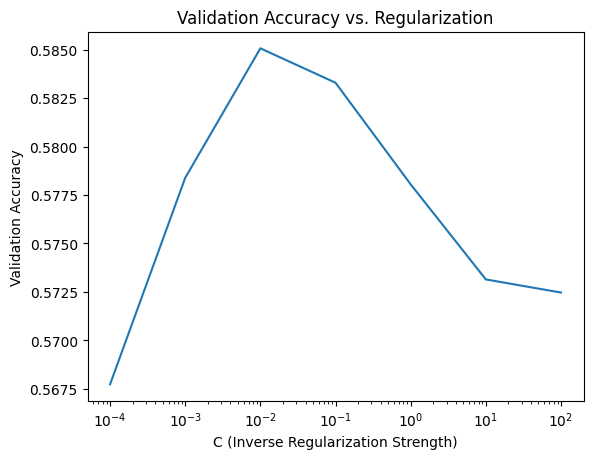

In [ ]:
regularization_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
validation_acc = []

for reg in regularization_values:
    model = LogisticRegression(C=reg, max_iter=10000)
    model.fit(X_train, y_train)
    accuracy = model.score(X_val, y_val)
    validation_acc.append(accuracy)
    best_index = validation_acc.index(max(validation_acc))
    best_c = regularization_values[best_index]
    print(f"C = {reg}, Validation Accuracy = {accuracy:.4f}, Current Best C = {best_c}")

best_index = validation_acc.index(max(validation_acc))
best_c = regularization_values[best_index]
print(f"Best C: {best_c}")

plt.plot(regularization_values, validation_acc)
plt.xscale('log')
plt.title('Validation Accuracy vs. Regularization')
plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Validation Accuracy')
plt.show()

In [9]:
logistic_final = LogisticRegression(
    C=0.01,
    max_iter=10000,
)
logistic_final.fit(X_entire_train, y_entire_train)
y_pred = logistic_final.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[5348   11  900]
 [ 806   20  456]
 [2909   23 1353]]
              precision    recall  f1-score   support

           0       0.59      0.85      0.70      6259
           1       0.37      0.02      0.03      1282
           2       0.50      0.32      0.39      4285

    accuracy                           0.57     11826
   macro avg       0.49      0.40      0.37     11826
weighted avg       0.53      0.57      0.51     11826



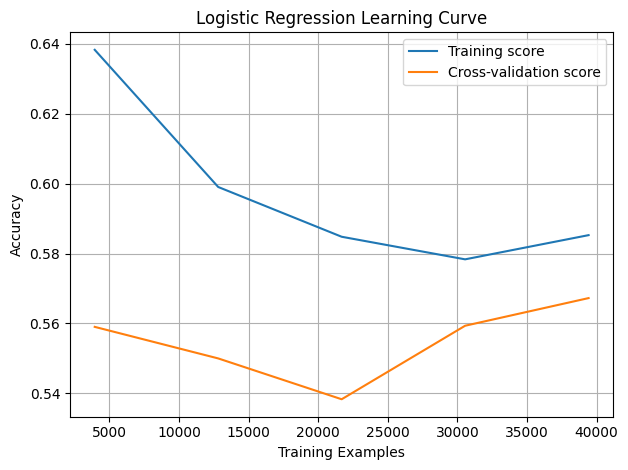

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    logistic_final, X, y, 
    cv=3,
    scoring='accuracy', 
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
plt.title("Logistic Regression Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.show()

In [15]:
# Removing the readmitted column from the training data because we will use this to classify
X = oversampled_df.drop("readmitted", axis=1)
y = oversampled_df["readmitted"]

In [16]:
# Initially splitting the data with using 20% for testing
# We use a random state of 13 throughout for reproducibility
X_entire_train, X_test, y_entire_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# Then, we split the remaining training data with 25% validation. 
# This way, we are using 20% of the entire data for validation and 60% for training.
X_train, X_val, y_train, y_val = train_test_split(X_entire_train, y_entire_train, test_size=0.25, random_state=13)

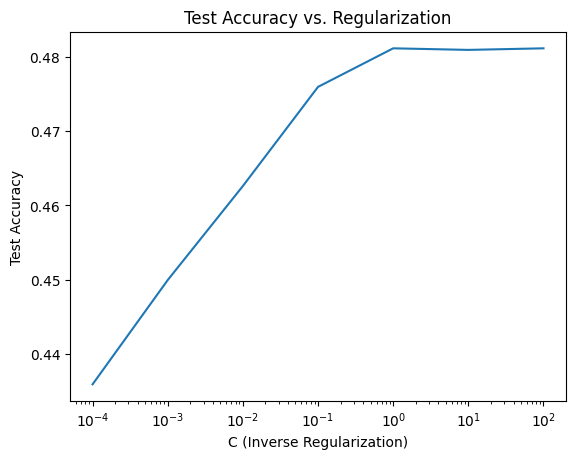

In [ ]:
regularization_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
validation_acc = []

for reg in regularization_values:
    model = LogisticRegression(C=reg, max_iter=10000)
    model.fit(X_train, y_train)
    accuracy = model.score(X_val, y_val)
    validation_acc.append(accuracy)
    best_index = validation_acc.index(max(validation_acc))
    best_c = regularization_values[best_index]
    print(f"C = {reg}, Validation Accuracy = {accuracy:.4f}, Current Best C = {best_c}")

best_index = validation_acc.index(max(validation_acc))
best_c = regularization_values[best_index]
print(f"Best C: {best_c}")

plt.plot(regularization_values, validation_acc)
plt.xscale('log') 
plt.title('Test Accuracy vs. Regularization')
plt.xlabel('C (Inverse Regularization)')
plt.ylabel('Test Accuracy')
plt.show()

In [18]:
logistic_final = LogisticRegression(
    C=best_c,
    max_iter=10000,
)
logistic_final.fit(X_entire_train, y_entire_train)
y_pred = logistic_final.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

c:\Users\neelu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[3419 1290 1585]
 [1600 3032 1603]
 [1976 1667 2703]]
              precision    recall  f1-score   support

           0       0.49      0.54      0.51      6294
           1       0.51      0.49      0.50      6235
           2       0.46      0.43      0.44      6346

    accuracy                           0.48     18875
   macro avg       0.48      0.49      0.48     18875
weighted avg       0.48      0.48      0.48     18875

